# Import

In [28]:

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# from plotly_resampler import FigureWidgetResampler

import os
import typing as tp

import wandb
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import importlib
from search_algorithms import *
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [73]:
import visualizatoin
import Model
import Maps

importlib.reload(visualizatoin)
importlib.reload(Model)
importlib.reload(Maps)

import visualizatoin
from Model import *
import Maps

In [6]:
%load_ext autoreload
%autoreload 2

# Code

In [7]:
def convert_string_to_cells(cell_str: str):
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "@" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [8]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> tp.Union[int, float]:
    if abs(i1 - i2) + abs(j1 - j2) == 1:
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return 2 ** 0.5
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal or diagonal moves are supported.")

In [9]:
def read_map(path):
    with open(path) as map_file:
        map_lines = [line for line in map_file.readlines()][2:-5]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

    return cells

In [10]:
def mse_loss(pred, target, cells):
    return nn.MSELoss()(pred[~torch.isinf(target)], target[~torch.isinf(target)])

# Model

In [11]:
path = './TransPath_data/train'
files = os.listdir(path)
def GetPath(name : int | str):
    if type(name) is int:
        return np.load(os.path.join(path, files[name]), mmap_mode='c')
    else:
        return np.load(os.path.join(path, name), mmap_mode='c')

In [12]:
class GridData(Dataset):
    def __init__(self, path, img_size=64):
        self.img_size = img_size

        self.maps = torch.tensor(np.load(os.path.join(path, 'maps.npy')))
        self.starts = torch.tensor(np.load(os.path.join(path, 'starts.npy')))
        self.goals = torch.tensor(np.load(os.path.join(path, 'goals.npy')))
        self.targets = torch.tensor(np.load(os.path.join(path, 'abs.npy')))

    def __len__(self):
        return len(self.maps)
    
    def get_with_all(self, idx):
        cells = self.maps[idx, 0]
        positions_map = self.goals[idx, 0]
        start_map = self.starts[idx, 0]
        shape = (-1, self.img_size, self.img_size)
        target = self.targets[idx, 0]
        return cells.reshape(shape).type(torch.float), \
            positions_map.reshape(shape).type(torch.float), \
                start_map.reshape(shape).type(torch.float), \
                    target.reshape(shape).type(torch.float)
    
    def __getitem__(self, idx):
        cells = self.maps[idx, 0]
        positions_map = self.goals[idx, 0]
        shape = (-1, self.img_size, self.img_size)
        target = self.targets[idx, 0]
        return cells.reshape(shape).type(torch.float), \
            positions_map.reshape(shape).type(torch.float), \
                target.reshape(shape).type(torch.float)

In [13]:
dataset_dir = './TransPath_data'
batch_size = 4
max_epochs = 3000
learning_rate = 1e-4
weight_decay = 0.0
limit_train_batches = 500
limit_val_batches = 100
run_name = 'default'
proj_name = 'motatasher_HS2_Alek'

In [14]:
train_data = GridData(
        path=f'{dataset_dir}/train',
    )
val_data = GridData(
        path=f'{dataset_dir}/val',
    )
resolution = (train_data.img_size, train_data.img_size)

In [15]:
card = train_data[0]

In [16]:
model = Model.UNet(2)

In [17]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    


class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down3 = (Down(128, 256 // factor))

        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


In [18]:
torch.serialization.add_safe_globals([nn.Conv2d])
torch.serialization.add_safe_globals([nn.Sequential])
torch.serialization.add_safe_globals([set])
torch.serialization.add_safe_globals([nn.BatchNorm2d])
torch.serialization.add_safe_globals([nn.ReLU])
torch.serialization.add_safe_globals([nn.MaxPool2d])
torch.serialization.add_safe_globals([nn.ConvTranspose2d]) 
 
torch.serialization.add_safe_globals([DoubleConv])
torch.serialization.add_safe_globals([Down])
torch.serialization.add_safe_globals([Up])
torch.serialization.add_safe_globals([OutConv])
torch.serialization.add_safe_globals([UNet])

torch.serialization.add_safe_globals([mse_loss])

In [20]:
cmap = plt.cm.viridis
cmap.set_bad(color=(0, 0, 0, 0))

In [ ]:
import visualizatoin
import Model
import Maps

importlib.reload(visualizatoin)
importlib.reload(Model)
importlib.reload(Maps)

import visualizatoin
from Model import *
import Maps

# TMP dataset

In [113]:
model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

[[51  9]] [[19 36]]


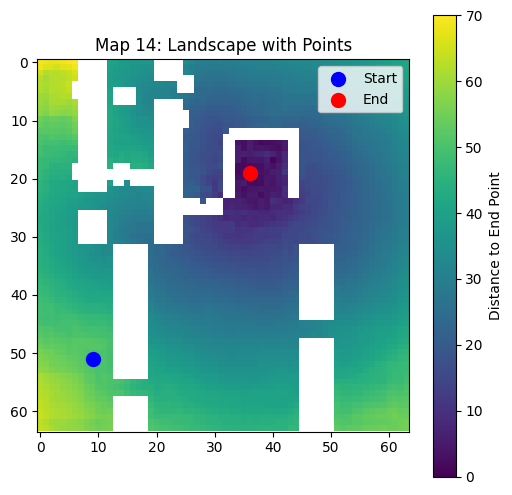

[[51  9]] [[19 36]]


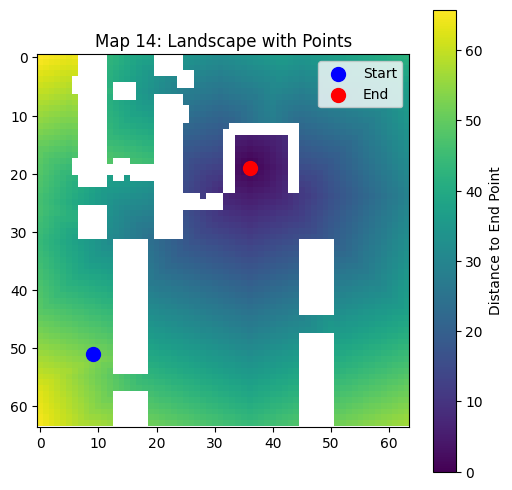

In [112]:
# for i in range(1):
# ind = np.random.randint(0, len(val_data))
# ind = 1
cells, positions_map, target = val_data[ind]
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy().squeeze(0)
predictions_true = target.numpy()

visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions)
visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions_true)

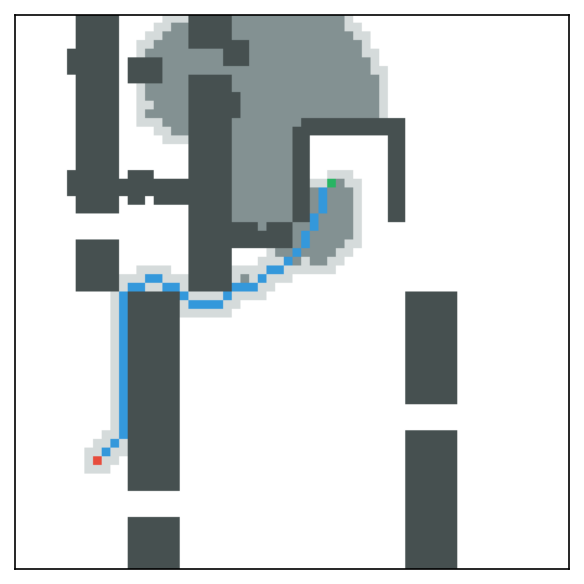

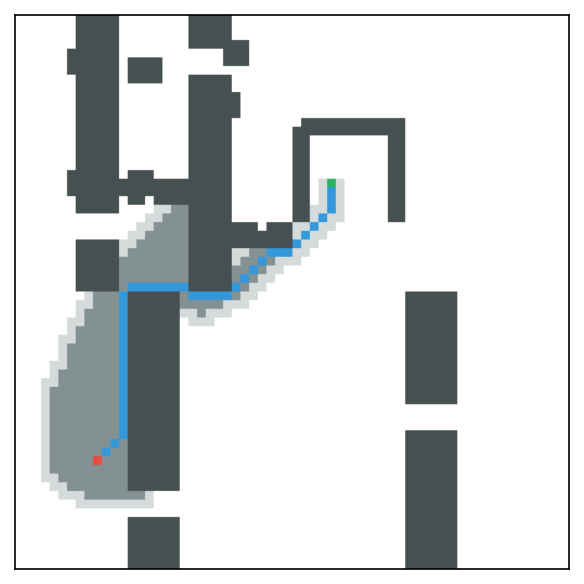

In [110]:
ind = 13
cells, starts, goals, target = val_data.get_with_all(ind)
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy()[0, 0]
predictions_true = target.numpy()[0]

map = Map(cells[0])
start_i, start_j = np.where(starts[0])
start_i, start_j = start_i[0], start_j[0]
goal_i, goal_j = np.where(goals[0])
goal_i, goal_j = goal_i[0], goal_j[0]

data = astar(map, goal_i, goal_j, start_i, start_j, predictions * 100, SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])


data = astar(map, goal_i, goal_j, start_i, start_j, octile_distance, SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])

# Before FineTuning

In [ ]:
model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [114]:
val_data = GridData(
        path=f'AlekSet/val',
    )

[[59 34]] [[14 17]]


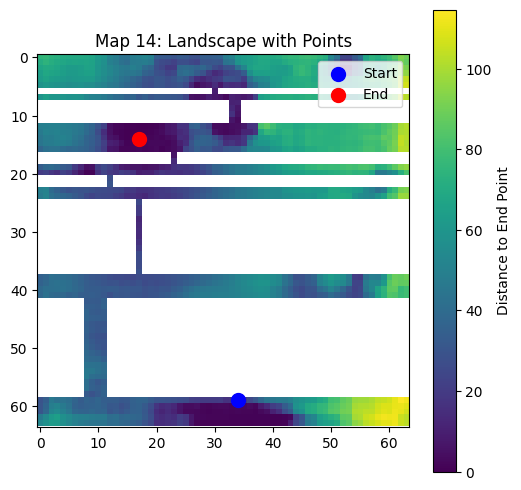

[[59 34]] [[14 17]]


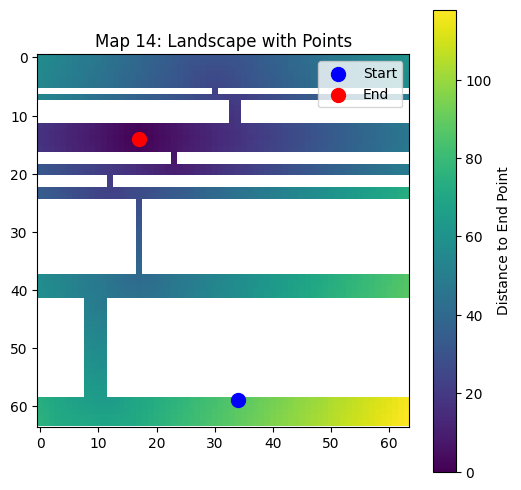

In [115]:
# for i in range(1):
# ind = np.random.randint(0, len(val_data))
# ind = 1
cells, positions_map, target = val_data[ind]
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy().squeeze(0)
predictions_true = target.numpy()

visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions)
visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions_true)

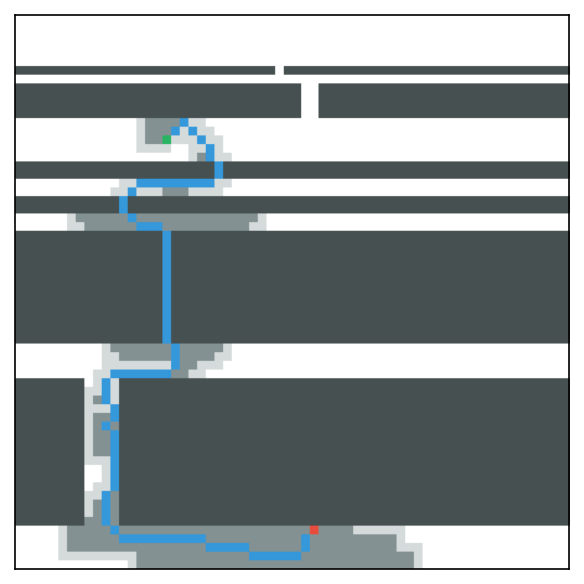

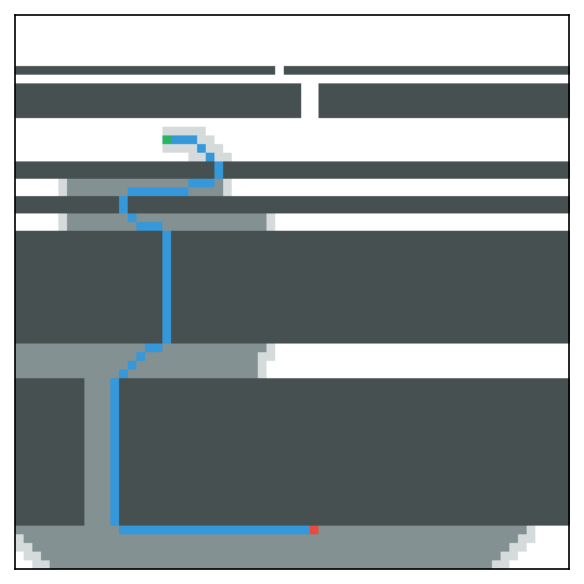

In [116]:
ind = 13
cells, starts, goals, target = val_data.get_with_all(ind)
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy()[0, 0]
predictions_true = target.numpy()[0]

map = Map(cells[0])
start_i, start_j = np.where(starts[0])
start_i, start_j = start_i[0], start_j[0]
goal_i, goal_j = np.where(goals[0])
goal_i, goal_j = goal_i[0], goal_j[0]

data = astar(map, goal_i, goal_j, start_i, start_j, predictions * 100, SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])


data = astar(map, goal_i, goal_j, start_i, start_j, octile_distance, SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])

# After FineTuning

In [118]:
model : UNet = torch.load('checkpoints_Alek/mode=0-epoch=999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [119]:
val_data = GridData(
        path=f'AlekSet/val',
    )

[[33 33]] [[25 48]]


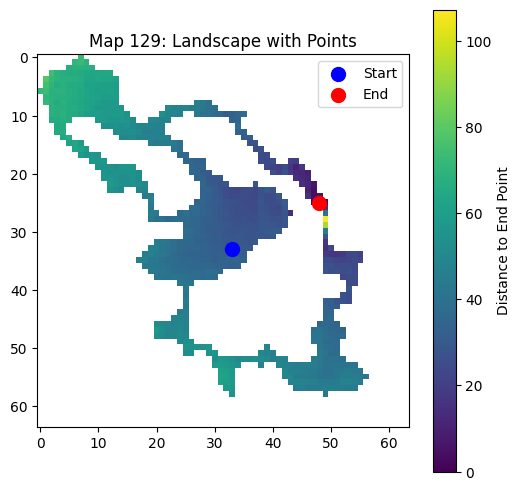

[[33 33]] [[25 48]]


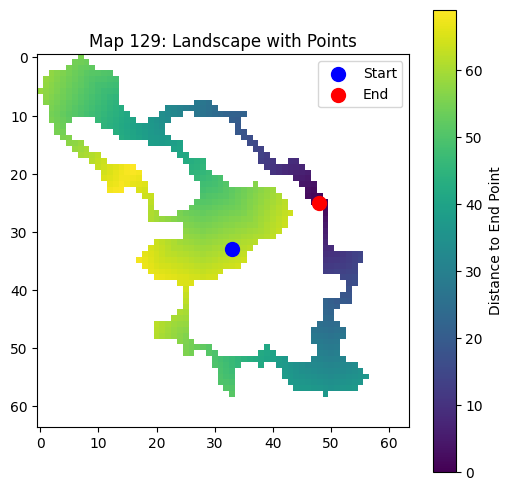

In [255]:
# for i in range(1):
# ind = np.random.randint(0, len(val_data))
# ind = 1
# ind = 98
cells, positions_map, target = val_data[ind]
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy().squeeze(0)
predictions_true = target.numpy()

visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions)
visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions_true)

1


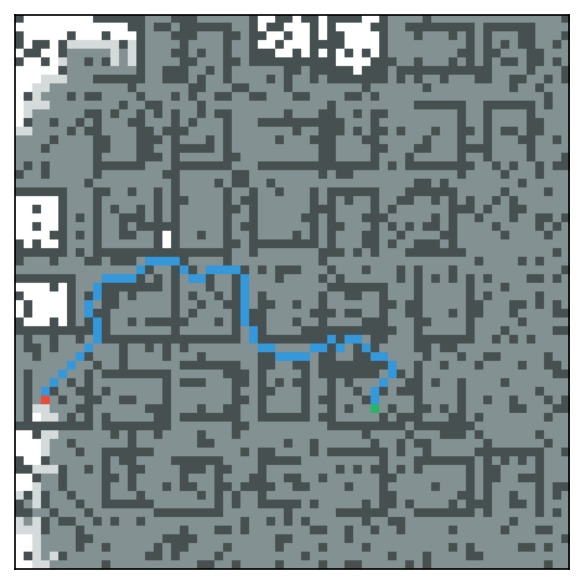

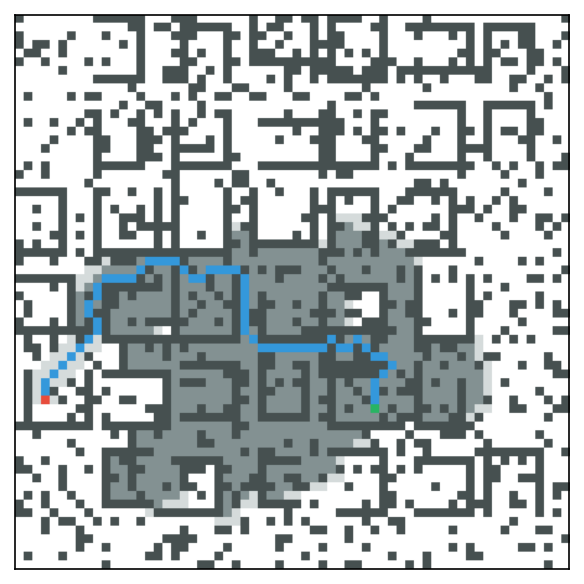

In [258]:
ind += 1
print(ind)
cells, starts, goals, target = val_data.get_with_all(ind)
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy()[0, 0]
predictions_true = target.numpy()[0]

map = Map(cells[0])
start_i, start_j = np.where(starts[0])
start_i, start_j = start_i[0], start_j[0]
goal_i, goal_j = np.where(goals[0])
goal_i, goal_j = goal_i[0], goal_j[0]

data = astar(map,
             start_i, start_j,
             goal_i, goal_j,
             predictions,
             SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])


data = astar(map,
             start_i, start_j,
             goal_i, goal_j,
             octile_distance, SearchTreePQD)
assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
path, length = make_path(data[1])
draw(
    map,
    Node(start_i, start_j),
    Node(goal_i, goal_j),
    path,
    data[-2],
    data[-1])